# 任务2 数据清洗(2天)
每一步都要认真完成，附上代码，最终效果截图

## 缺失值分析及处理

* 缺失值出现的原因分析
* 采取合适的方式对缺失值进行填充

## 异常值分析及处理

* 根据测试集数据的分布处理训练集的数据分布

* 使用合适的方法找出异常值
* 对异常值进行处理

## 深度清洗

* 分析每一个communityName、city、region、plate的数据分布并对其进行数据清洗





## 简要分析
在任务一中，我们对于赛题、数据总体情况、缺失值、特征分布等信息做了简要的分析。在本次任务中就是基于任务一的分析做数据清理工作。  
在一些场景中，任务一和任务二合并起来会被称作EDA(Exploratory Data Analysis-探索性数据分析)。当然真正的EDA包含的内容远不止这两份参考示例所展示了，大家可以自行学习尝试。  
  



参考资料：   
[一文带你探索性数据分析(EDA)
](https://www.jianshu.com/p/9325c9f88ee6)

# 缺失值处理

In [2]:
#coding:utf-8
#导入warnings包，利用过滤器来实现忽略警告语句。
import warnings
warnings.filterwarnings('ignore')

# GBDT
#from sklearn.ensemble import GradientBoostingRegressor
# XGBoost
#import xgboost as xgb
# LightGBM
#import lightgbm as lgb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
import pickle
import multiprocessing
from sklearn.preprocessing import StandardScaler
ss = StandardScaler() 
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC,LinearRegression,LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

In [4]:
#载入数据
data_train = pd.read_csv('数据集/train_data.csv')
data_train['Type'] = 'Train'
data_test = pd.read_csv('数据集/test_a.csv')
data_test['Type'] = 'Test'
data_all = pd.concat([data_train, data_test], ignore_index=True)

In [11]:
pd.set_option('max_column',1000)
pd.set_option('max_row',300)
data_train.head()

,ID,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,region,plate,buildYear,saleSecHouseNum,subwayStationNum,busStationNum,interSchoolNum,schoolNum,privateSchoolNum,hospitalNum,drugStoreNum,gymNum,bankNum,shopNum,parkNum,mallNum,superMarketNum,totalTradeMoney,totalTradeArea,tradeMeanPrice,tradeSecNum,totalNewTradeMoney,totalNewTradeArea,tradeNewMeanPrice,tradeNewNum,remainNewNum,supplyNewNum,supplyLandNum,supplyLandArea,tradeLandNum,tradeLandArea,landTotalPrice,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeTime,tradeMoney,Type
0,100309852,68.06,未知方式,2室1厅1卫,低,16,暂无数据,其他,XQ00051,SH,RG00001,BK00064,1953,0,7,36,0,28,1,1,12,15,16,76,5,3,22,355584000,7411.98,47974.22551,111,810967373,7755,104573.48460,25,264,0,0,0.0,0,0.0,0,0.0000,28248,614,111546,1124.0,284.0,0,2018/11/28,2000.0,Train
1,100307942,125.55,未知方式,3室2厅2卫,中,14,暂无数据,简装,XQ00130,SH,RG00002,BK00049,2007,0,2,184,0,26,0,1,27,5,16,163,6,4,51,5000000,122.83,40706.66775,2,9668955,286,33807.53497,2,4,0,0,0.0,0,0.0,0,0.0000,14823,148,157552,701.0,22.0,1,2018/12/16,2000.0,Train
2,100307764,132.00,未知方式,3室2厅2卫,低,32,暂无数据,其他,XQ00179,SH,RG00002,BK00050,暂无信息,3,6,60,1,43,2,3,24,35,37,85,6,4,30,1687284798,49071.30,34384.35089,555,344894466,3143,109734.16040,11,159,126,0,0.0,0,0.0,0,0.0000,77645,520,131744,57.0,20.0,1,2018/12/22,16000.0,Train
3,100306518,57.00,未知方式,1室1厅1卫,中,17,暂无数据,精装,XQ00313,SH,RG00002,BK00051,暂无信息,0,3,364,2,60,1,8,83,30,47,358,3,1,131,468272888,22809.70,20529.55050,260,196307819,6418,30587.07058,58,730,0,1,108037.8,1,108037.8,332760000,3080.0331,8750,1665,253337,888.0,279.0,9,2018/12/21,1600.0,Train
4,100305262,129.00,未知方式,3室2厅3卫,低,2,暂无数据,毛坯,XQ01257,SH,RG00003,BK00044,暂无信息,1,0,141,0,15,0,0,21,5,10,100,5,2,34,108851470,4463.62,24386.36577,38,286722058,5608,51127.32846,34,851,216,0,0.0,0,0.0,0,0.0000,800,117,125309,2038.0,480.0,0,2018/11/18,2900.0,Train


## 主要思路分析
虽然这步骤是缺失值处理，但还会涉及到一些最最基础的数据处理。  
1. **缺失值处理**  
缺失值的处理手段大体可以分为：删除、填充、映射到高维(当做类别处理)。  
详细的请自行查找相关资料学习。  
根据任务一，直接找到的缺失值情况是pu和pv；但是，根据特征nunique分布的分析，可以发现rentType存在"--"的情况，这也算是一种缺失值。  
此外，诸如rentType的"未知方式"；houseToward的"暂无数据"等，本质上也算是一种缺失值，但是对于这些缺失方式，我们可以把它当做是特殊的一类处理，而不需要去主动修改或填充值。  
  
  将rentType的"--"转换成"未知方式"类别；  
  pv/pu的缺失值用均值填充；  
  buildYear存在"暂无信息"，将其用众数填充。  
  
    
2. **转换object类型数据**  
这里直接采用LabelEncoder的方式编码，详细的编码方式请自行查阅相关资料学习。  
  
  
3. **时间字段的处理**  
buildYear由于存在"暂无信息",所以需要主动将其转换int类型；  
tradeTime，将其分割成月和日。  
  
  
4. **删除无关字段**  
ID是唯一码，建模无用，所以直接删除；  
city只有一个SH值，也直接删除；  
tradeTime已经分割成月和日，删除原来字段

缺失值处理

1.缺失值分析

首先分析pv uv 的变化情况

In [6]:
from pandas.plotting import scatter_matrix

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001A8064E0>,
      dtype=object)

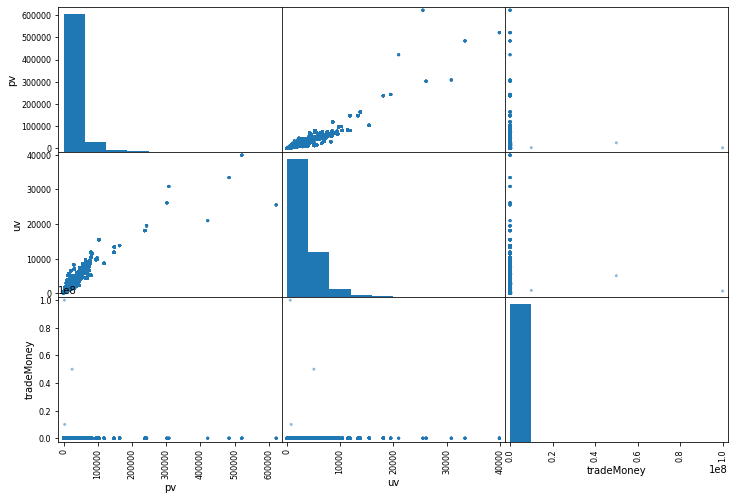

In [13]:
scatter_matrix(data_train[["pv","uv","tradeMoney"]],figsize=(12,8))

可以感觉到pv uv是成正比的 也符合常识,我们来看一看pv uv 和其他特征的相关性


In [15]:
corr_matrix = data_train.corr()

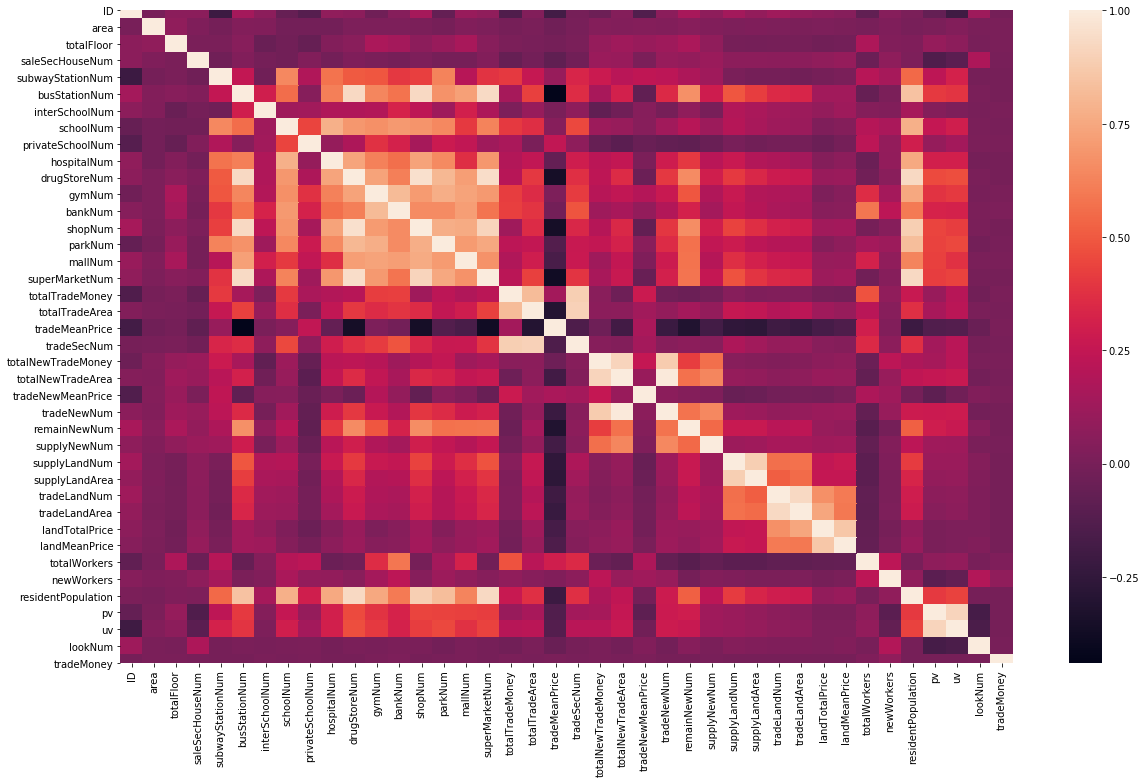

In [26]:
plt.figure(figsize=(20,12))
sns.heatmap(corr_matrix)

由相关性可知 pv uv 和版块的信息相关性较高 
那有几个问题 plate和region 是否一一对应呢
我们先把数据提取出来

In [20]:
def missing_values(df):
    '''
    df.isnull() 返回的是DataFrame
    df.sum() 返回的是Series index是column name
    len(df) 返回的是行数
    '''
    alldata_na = pd.DataFrame(df.isnull().sum(), columns={'missingNum'})
    alldata_na['existNum'] = len(df) - alldata_na['missingNum']
    alldata_na['sum'] = len(df)
    alldata_na['missingRatio'] = alldata_na['missingNum']/len(df)*100
    alldata_na['dtype'] = df.dtypes
    #ascending：默认True升序排列；False降序排列
    alldata_na = alldata_na[alldata_na['missingNum']>0]
    '''
    因为column name是标签 所以这里要先用reset_index() 把标签提进来
    列名为index
    ?如何更改列名
    '''
    alldata_na=alldata_na.reset_index().sort_values(by=['missingNum'],ascending=[True])
    
    alldata_na.set_index('index',inplace=True)
    return alldata_na

missing_values_=missing_values(data_train)
missing_values_
def missing_data(missing_df,data_train):
    index=missing_df.index
    missing_data=pd.DataFrame()
    for x in index:
        missing_data=pd.concat([missing_data,data_train[data_train[x].isnull()]])
    missing_data.drop_duplicates(inplace=True)
    return missing_data

missing_data_=missing_data(missing_values_,data_train)
missing_data_

,ID,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,region,plate,buildYear,saleSecHouseNum,subwayStationNum,busStationNum,interSchoolNum,schoolNum,privateSchoolNum,hospitalNum,drugStoreNum,gymNum,bankNum,shopNum,parkNum,mallNum,superMarketNum,totalTradeMoney,totalTradeArea,tradeMeanPrice,tradeSecNum,totalNewTradeMoney,totalNewTradeArea,tradeNewMeanPrice,tradeNewNum,remainNewNum,supplyNewNum,supplyLandNum,supplyLandArea,tradeLandNum,tradeLandArea,landTotalPrice,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeTime,tradeMoney,Type
4370,100312249,63.26,--,1室2厅1卫,低,30,南,其他,XQ03008,SH,RG00009,BK00024,2003,0,3,24,1,45,1,6,15,39,69,140,1,4,21,0,0.0,0.0,0,11799846,138,85506.13043,1,41,0,0,0.0,0,0.0,0,0.0,102958,492,70013,NaN,NaN,0,2018/12/6,10700.0,Train
4373,100312226,46.55,整租,2室1厅1卫,低,6,南,精装,XQ02996,SH,RG00009,BK00024,1983,0,3,24,1,45,1,6,15,39,69,140,1,4,21,0,0.0,0.0,0,11799846,138,85506.13043,1,41,0,0,0.0,0,0.0,0,0.0,102958,492,70013,NaN,NaN,6,2018/12/23,6000.0,Train
4376,100312218,100.20,整租,2室2厅1卫,中,32,南,精装,XQ02979,SH,RG00009,BK00024,2004,1,3,24,1,45,1,6,15,39,69,140,1,4,21,0,0.0,0.0,0,11799846,138,85506.13043,1,41,0,0,0.0,0,0.0,0,0.0,102958,492,70013,NaN,NaN,4,2018/12/15,13800.0,Train
4379,100312213,43.20,整租,1室1厅1卫,高,7,南,精装,XQ03016,SH,RG00009,BK00024,1987,0,3,24,1,45,1,6,15,39,69,140,1,4,21,0,0.0,0.0,0,11799846,138,85506.13043,1,41,0,0,0.0,0,0.0,0,0.0,102958,492,70013,NaN,NaN,14,2018/12/18,4500.0,Train
4387,100312196,24.81,整租,1室0厅1卫,中,6,南,精装,XQ02994,SH,RG00009,BK00024,1988,1,3,24,1,45,1,6,15,39,69,140,1,4,21,0,0.0,0.0,0,11799846,138,85506.13043,1,41,0,0,0.0,0,0.0,0,0.0,102958,492,70013,NaN,NaN,1,2018/12/17,5600.0,Train
4391,100312188,65.11,整租,2室1厅1卫,低,24,南,简装,XQ02993,SH,RG00009,BK00024,1992,4,3,24,1,45,1,6,15,39,69,140,1,4,21,0,0.0,0.0,0,11799846,138,85506.13043,1,41,0,0,0.0,0,0.0,0,0.0,102958,492,70013,NaN,NaN,10,2018/12/20,6000.0,Train
4392,100312179,55.00,整租,1室1厅1卫,中,6,南,其他,XQ02963,SH,RG00009,BK00024,1953,0,3,24,1,45,1,6,15,39,69,140,1,4,21,0,0.0,0.0,0,11799846,138,85506.13043,1,41,0,0,0.0,0,0.0,0,0.0,102958,492,70013,NaN,NaN,2,2018/12/21,6300.0,Train
4396,100312169,49.00,--,2室1厅1卫,低,7,南,其他,XQ03002,SH,RG00009,BK00024,1988,2,3,24,1,45,1,6,15,39,69,140,1,4,21,0,0.0,0.0,0,11799846,138,85506.13043,1,41,0,0,0.0,0,0.0,0,0.0,102958,492,70013,NaN,NaN,9,2018/12/23,8400.0,Train
4399,100312163,23.91,整租,1室0厅1卫,中,6,南,简装,XQ02994,SH,RG00009,BK00024,1988,1,3,24,1,45,1,6,15,39,69,140,1,4,21,0,0.0,0.0,0,11799846,138,85506.13043,1,41,0,0,0.0,0,0.0,0,0.0,102958,492,70013,NaN,NaN,7,2018/12/21,3700.0,Train
4428,100312036,37.80,--,1室1厅1卫,高,7,南,其他,XQ03002,SH,RG00009,BK00024,1988,2,3,24,1,45,1,6,15,39,69,140,1,4,21,0,0.0,0.0,0,11799846,138,85506.13043,1,41,0,0,0.0,0,0.0,0,0.0,102958,492,70013,NaN,NaN,0,2018/12/3,5300.0,Train


之后考察plate 和region的关系

In [30]:
print(data_train[data_train["plate"]=="BK00024"]["region"].value_counts())
print(data_train[data_train["region"]=="RG00009"]["plate"].value_counts())

RG00009    397
Name: region, dtype: int64
BK00024    397
BK00025    157
BK00023    127
Name: plate, dtype: int64


一个region 对应3个plate
之后考察plate BK00024中pv的变化情况

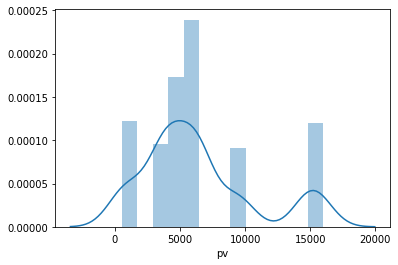

In [33]:
sns.distplot(data_train[data_train["plate"]=="BK00024"]['pv'].dropna())

从图上来看有低的时候有高的时候
既然是月浏览量 下面我们看与时间的关系

In [52]:
data_train['tradeTime'] = data_train['tradeTime'].astype('datetime64[ns]')
dt=data_train[data_train["plate"]=="BK00024"].sort_values(by='tradeTime')
dt.tail(100)

,ID,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,region,plate,buildYear,saleSecHouseNum,subwayStationNum,busStationNum,interSchoolNum,schoolNum,privateSchoolNum,hospitalNum,drugStoreNum,gymNum,bankNum,shopNum,parkNum,mallNum,superMarketNum,totalTradeMoney,totalTradeArea,tradeMeanPrice,tradeSecNum,totalNewTradeMoney,totalNewTradeArea,tradeNewMeanPrice,tradeNewNum,remainNewNum,supplyNewNum,supplyLandNum,supplyLandArea,tradeLandNum,tradeLandArea,landTotalPrice,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeTime,tradeMoney,Type
24794,100072645,30.35,整租,1室1厅1卫,高,6,南,简装,XQ02963,SH,RG00009,BK00024,1953,3,3,24,1,45,1,6,15,39,69,140,1,4,21,0,0.0,0.0,0,41280383,373,110671.26810,2,44,0,0,0.0,0,0.0,0,0.0,102958,0,70013,4157.0,873.0,0,2018-09-07,3300.0,Train
21391,100092645,135.54,未知方式,3室2厅2卫,高,32,南,其他,XQ02967,SH,RG00009,BK00024,2003,0,3,24,1,45,1,6,15,39,69,140,1,4,21,0,0.0,0.0,0,41280383,373,110671.26810,2,44,0,0,0.0,0,0.0,0,0.0,102958,0,70013,4157.0,873.0,0,2018-09-08,15500.0,Train
12175,100191900,34.47,未知方式,1室1厅1卫,中,6,南,其他,XQ03000,SH,RG00009,BK00024,1983,1,3,24,1,45,1,6,15,39,69,140,1,4,21,0,0.0,0.0,0,41280383,373,110671.26810,2,44,0,0,0.0,0,0.0,0,0.0,102958,0,70013,4157.0,873.0,0,2018-09-09,4800.0,Train
16033,100129725,68.52,未知方式,1室2厅1卫,低,32,南,其他,XQ02967,SH,RG00009,BK00024,2003,0,3,24,1,45,1,6,15,39,69,140,1,4,21,0,0.0,0.0,0,41280383,373,110671.26810,2,44,0,0,0.0,0,0.0,0,0.0,102958,0,70013,4157.0,873.0,0,2018-09-09,8300.0,Train
23084,100082633,31.40,整租,1室1厅1卫,低,7,南,简装,XQ03013,SH,RG00009,BK00024,1988,2,3,24,1,45,1,6,15,39,69,140,1,4,21,0,0.0,0.0,0,41280383,373,110671.26810,2,44,0,0,0.0,0,0.0,0,0.0,102958,0,70013,4157.0,873.0,0,2018-09-09,4100.0,Train
22067,100088633,189.00,未知方式,3室2厅2卫,中,24,南,其他,XQ02971,SH,RG00009,BK00024,2004,0,3,24,1,45,1,6,15,39,69,140,1,4,21,0,0.0,0.0,0,41280383,373,110671.26810,2,44,0,0,0.0,0,0.0,0,0.0,102958,0,70013,4157.0,873.0,0,2018-09-10,13000.0,Train
1055,100104542,89.00,整租,2室2厅1卫,低,26,西南,精装,XQ02979,SH,RG00009,BK00024,2004,2,3,24,1,45,1,6,15,39,69,140,1,4,21,0,0.0,0.0,0,41280383,373,110671.26810,2,44,0,0,0.0,0,0.0,0,0.0,102958,0,70013,4157.0,873.0,0,2018-09-15,10500.0,Train
17911,100114452,64.52,未知方式,2室1厅1卫,中,29,南,其他,XQ02993,SH,RG00009,BK00024,1992,5,3,24,1,45,1,6,15,39,69,140,1,4,21,0,0.0,0.0,0,41280383,373,110671.26810,2,44,0,0,0.0,0,0.0,0,0.0,102958,0,70013,4157.0,873.0,0,2018-09-16,6800.0,Train
22416,100086633,55.00,未知方式,2室1厅1卫,高,6,南,其他,XQ02987,SH,RG00009,BK00024,1982,0,3,24,1,45,1,6,15,39,69,140,1,4,21,0,0.0,0.0,0,41280383,373,110671.26810,2,44,0,0,0.0,0,0.0,0,0.0,102958,0,70013,4157.0,873.0,0,2018-09-16,7500.0,Train
25859,100066633,108.91,未知方式,2室2厅1卫,中,32,南,其他,XQ02968,SH,RG00009,BK00024,1999,3,3,24,1,45,1,6,15,39,69,140,1,4,21,0,0.0,0.0,0,41280383,373,110671.26810,2,44,0,0,0.0,0,0.0,0,0.0,102958,0,70013,4157.0,873.0,0,2018-09-17,11500.0,Train


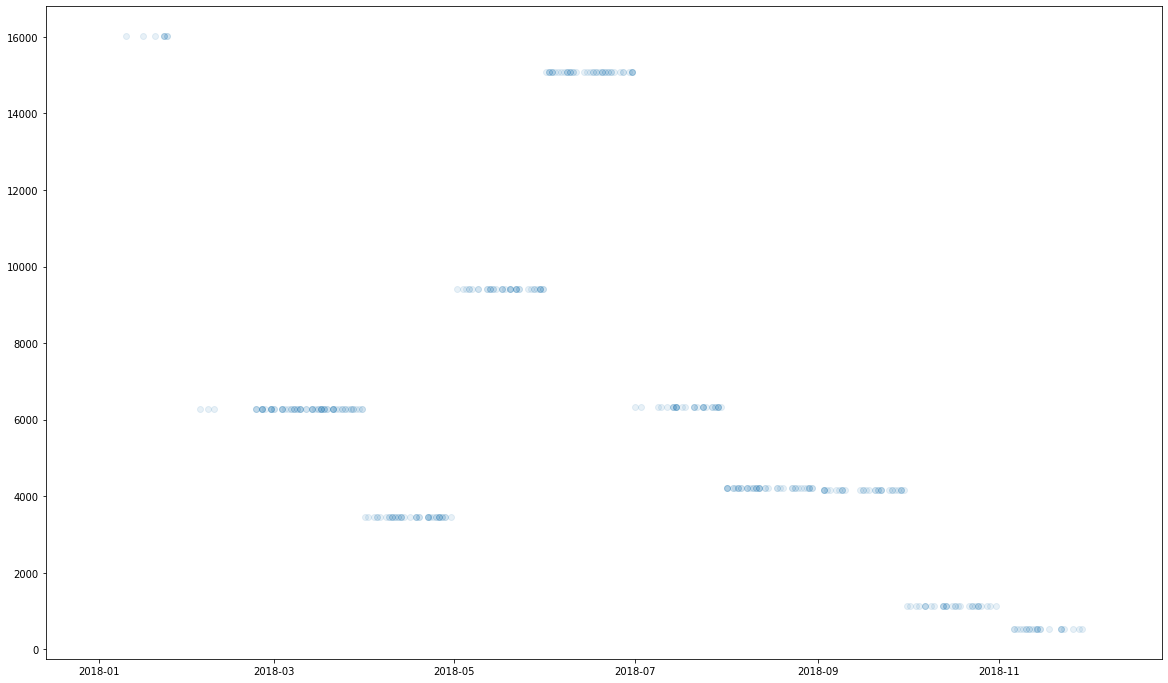

In [49]:
plt.figure(figsize=(20,12))
plt.scatter(dt['tradeTime'],dt['pv'],alpha=0.1)

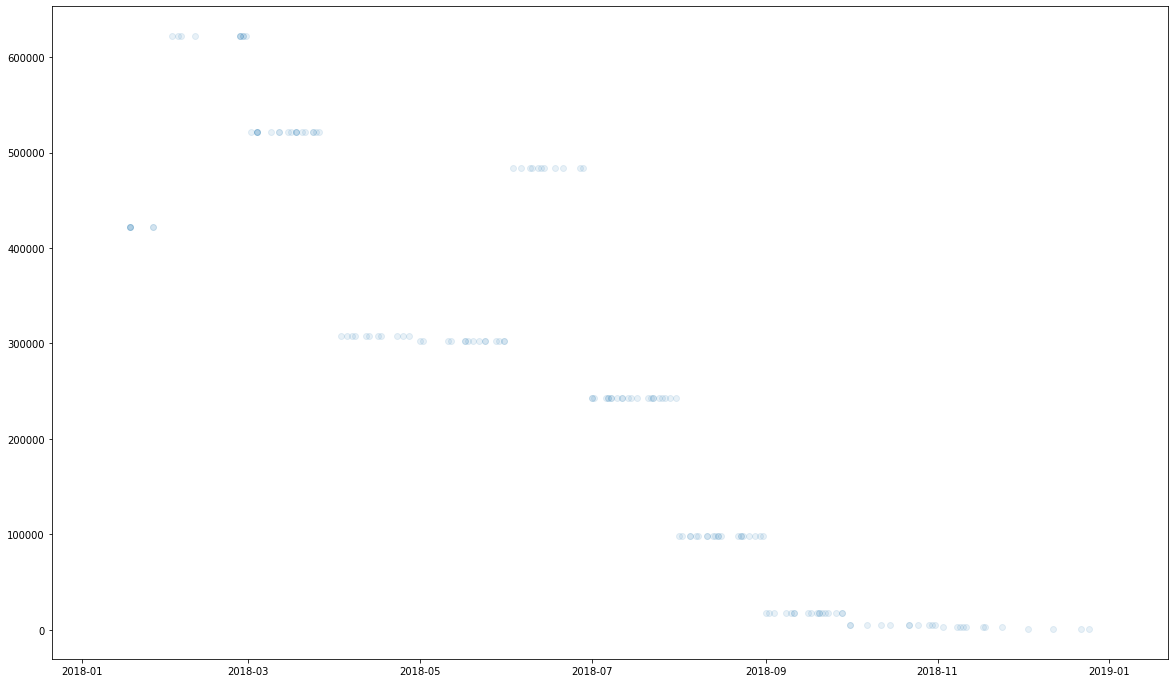

In [50]:
dt2=data_train[data_train["plate"]=="BK00025"].sort_values(by='tradeTime')
plt.figure(figsize=(20,12))
plt.scatter(dt2['tradeTime'],dt2['pv'],alpha=0.1)


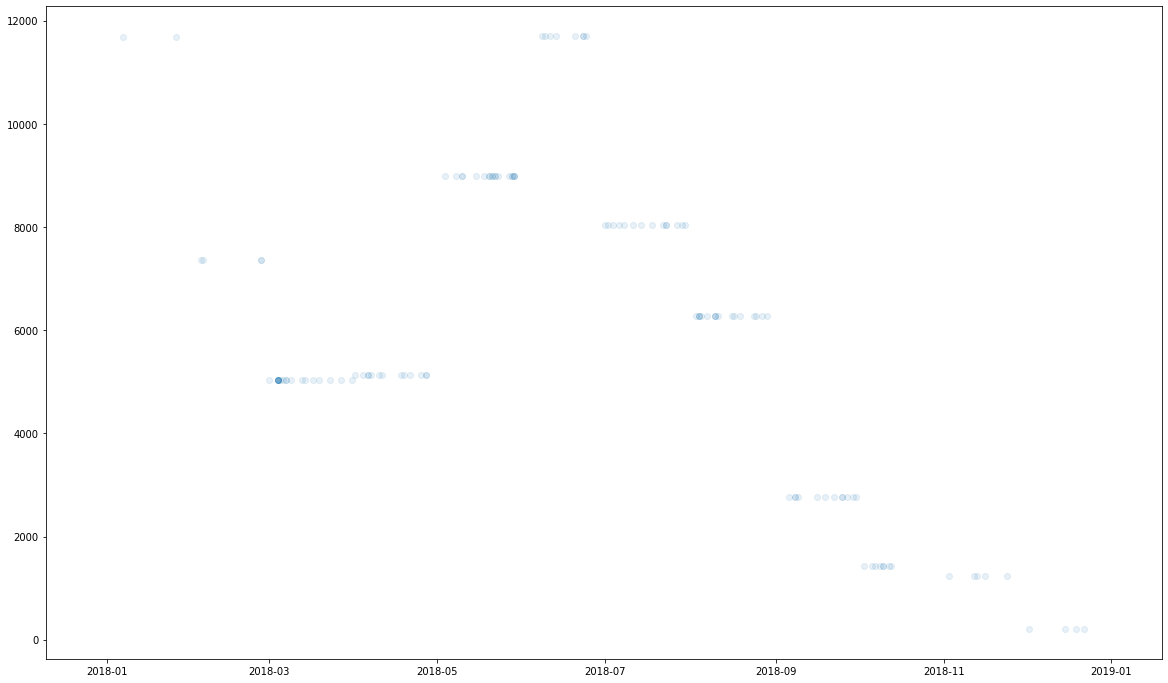

In [51]:
dt3=data_train[data_train["plate"]=="BK00023"].sort_values(by='tradeTime')
plt.figure(figsize=(20,12))
plt.scatter(dt3['tradeTime'],dt3['pv'],alpha=0.1)


从其他plate来看,总体上大家的点击是相似的,12月的值在11月的下面

根据其他两个盘11月与12月的比例情况预计12月的pv uv


In [57]:
dt2.tail(100)

,ID,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,region,plate,buildYear,saleSecHouseNum,subwayStationNum,busStationNum,interSchoolNum,schoolNum,privateSchoolNum,hospitalNum,drugStoreNum,gymNum,bankNum,shopNum,parkNum,mallNum,superMarketNum,totalTradeMoney,totalTradeArea,tradeMeanPrice,tradeSecNum,totalNewTradeMoney,totalNewTradeArea,tradeNewMeanPrice,tradeNewNum,remainNewNum,supplyNewNum,supplyLandNum,supplyLandArea,tradeLandNum,tradeLandArea,landTotalPrice,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeTime,tradeMoney,Type
11815,100197379,198.81,整租,3室2厅2卫,高,33,南,精装,XQ03040,SH,RG00009,BK00025,2002,0,3,70,0,47,4,6,29,38,98,245,5,14,29,935310000,11659.39,80219.46260,139,0,0,0.0,0,0,0,0,0.0,0,0.0,0,0.0,338301,0,102698,302125.0,26122.0,0,2018-05-28,19000.0,Train
8507,100260079,151.04,整租,3室2厅2卫,低,33,南,精装,XQ03028,SH,RG00009,BK00025,1999,0,3,70,0,47,4,6,29,38,98,245,5,14,29,935310000,11659.39,80219.46260,139,0,0,0.0,0,0,0,0,0.0,0,0.0,0,0.0,338301,0,102698,302125.0,26122.0,0,2018-05-29,18000.0,Train
39810,100207378,13.00,整租,1室0厅1卫,低,3,北,简装,XQ03043,SH,RG00009,BK00025,暂无信息,0,3,70,0,47,4,6,29,38,98,245,5,14,29,935310000,11659.39,80219.46260,139,0,0,0.0,0,0,0,0,0.0,0,0.0,0,0.0,338301,0,102698,302125.0,26122.0,0,2018-05-31,2200.0,Train
39710,100230279,13.00,未知方式,1室0厅1卫,低,3,北,其他,XQ03043,SH,RG00009,BK00025,暂无信息,0,3,70,0,47,4,6,29,38,98,245,5,14,29,935310000,11659.39,80219.46260,139,0,0,0.0,0,0,0,0,0.0,0,0.0,0,0.0,338301,0,102698,302125.0,26122.0,0,2018-05-31,2200.0,Train
12185,100191383,72.93,整租,1室2厅1卫,低,24,南,精装,XQ03046,SH,RG00009,BK00025,2006,0,3,70,0,47,4,6,29,38,98,245,5,14,29,782140000,19798.16,39505.69144,315,0,0,0.0,0,0,0,0,0.0,0,0.0,0,0.0,338301,0,102698,483899.0,33420.0,0,2018-06-03,9800.0,Train
14360,100151110,68.55,整租,1室2厅1卫,中,5,南,简装,XQ03069,SH,RG00009,BK00025,1936,0,3,70,0,47,4,6,29,38,98,245,5,14,29,782140000,19798.16,39505.69144,315,0,0,0.0,0,0,0,0,0.0,0,0.0,0,0.0,338301,0,102698,483899.0,33420.0,0,2018-06-06,7000.0,Train
11816,100197378,172.28,整租,3室2厅2卫,低,30,南,精装,XQ03042,SH,RG00009,BK00025,2004,0,3,70,0,47,4,6,29,38,98,245,5,14,29,782140000,19798.16,39505.69144,315,0,0,0.0,0,0,0,0,0.0,0,0.0,0,0.0,338301,0,102698,483899.0,33420.0,0,2018-06-09,14600.0,Train
10365,100219378,25.00,整租,2室0厅1卫,中,5,南,简装,XQ03044,SH,RG00009,BK00025,1931,0,3,70,0,47,4,6,29,38,98,245,5,14,29,782140000,19798.16,39505.69144,315,0,0,0.0,0,0,0,0,0.0,0,0.0,0,0.0,338301,0,102698,483899.0,33420.0,0,2018-06-10,3800.0,Train
9888,100230278,21.00,未知方式,1室1厅1卫,低,6,南,其他,XQ03055,SH,RG00009,BK00025,1910,0,3,70,0,47,4,6,29,38,98,245,5,14,29,782140000,19798.16,39505.69144,315,0,0,0.0,0,0,0,0,0.0,0,0.0,0,0.0,338301,0,102698,483899.0,33420.0,0,2018-06-12,3700.0,Train
13135,100174292,91.49,未知方式,2室2厅1卫,中,28,南,其他,XQ03046,SH,RG00009,BK00025,2006,0,3,70,0,47,4,6,29,38,98,245,5,14,29,782140000,19798.16,39505.69144,315,0,0,0.0,0,0,0,0,0.0,0,0.0,0,0.0,338301,0,102698,483899.0,33420.0,0,2018-06-13,12500.0,Train


In [58]:
dt3.tail(100)

,ID,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,region,plate,buildYear,saleSecHouseNum,subwayStationNum,busStationNum,interSchoolNum,schoolNum,privateSchoolNum,hospitalNum,drugStoreNum,gymNum,bankNum,shopNum,parkNum,mallNum,superMarketNum,totalTradeMoney,totalTradeArea,tradeMeanPrice,tradeSecNum,totalNewTradeMoney,totalNewTradeArea,tradeNewMeanPrice,tradeNewNum,remainNewNum,supplyNewNum,supplyLandNum,supplyLandArea,tradeLandNum,tradeLandArea,landTotalPrice,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeTime,tradeMoney,Type
7524,100285217,164.17,未知方式,3室2厅2卫,低,30,南,精装,XQ02950,SH,RG00009,BK00023,1999,0,3,47,0,57,2,3,20,18,50,224,4,5,21,346160000,5088.90,68022.55890,77,189313932,1315,143964.9673,4,52,0,0,0.0,0,0.0,0,0.0,93770,0,186642,5140.0,698.0,0,2018-04-01,16500.0,Train
9886,100230346,117.12,未知方式,2室2厅1卫,中,33,南,精装,XQ02918,SH,RG00009,BK00023,2003,0,3,47,0,57,2,3,20,18,50,224,4,5,21,346160000,5088.90,68022.55890,77,189313932,1315,143964.9673,4,52,0,0,0.0,0,0.0,0,0.0,93770,0,186642,5140.0,698.0,0,2018-04-04,12000.0,Train
13132,100174360,40.43,未知方式,1室0厅0卫,低,12,南,其他,XQ02918,SH,RG00009,BK00023,2003,0,3,47,0,57,2,3,20,18,50,224,4,5,21,346160000,5088.90,68022.55890,77,189313932,1315,143964.9673,4,52,0,0,0.0,0,0.0,0,0.0,93770,0,186642,5140.0,698.0,0,2018-04-06,650.0,Train
39823,100205445,12.60,合租,4室1厅1卫,低,28,北,精装,XQ02955,SH,RG00009,BK00023,1999,0,3,47,0,57,2,3,20,18,50,224,4,5,21,346160000,5088.90,68022.55890,77,189313932,1315,143964.9673,4,52,0,0,0.0,0,0.0,0,0.0,93770,0,186642,5140.0,698.0,0,2018-04-06,3490.0,Train
12430,100187450,33.90,未知方式,1室1厅1卫,低,6,南,其他,XQ02951,SH,RG00009,BK00023,1983,0,3,47,0,57,2,3,20,18,50,224,4,5,21,346160000,5088.90,68022.55890,77,189313932,1315,143964.9673,4,52,0,0,0.0,0,0.0,0,0.0,93770,0,186642,5140.0,698.0,0,2018-04-07,4500.0,Train
11813,100197445,39.00,未知方式,1室1厅1卫,高,6,南,其他,XQ02948,SH,RG00009,BK00023,1990,0,3,47,0,57,2,3,20,18,50,224,4,5,21,346160000,5088.90,68022.55890,77,189313932,1315,143964.9673,4,52,0,0,0.0,0,0.0,0,0.0,93770,0,186642,5140.0,698.0,0,2018-04-10,3900.0,Train
10361,100219445,114.85,未知方式,2室2厅1卫,低,33,南,精装,XQ02918,SH,RG00009,BK00023,2003,0,3,47,0,57,2,3,20,18,50,224,4,5,21,346160000,5088.90,68022.55890,77,189313932,1315,143964.9673,4,52,0,0,0.0,0,0.0,0,0.0,93770,0,186642,5140.0,698.0,0,2018-04-11,13000.0,Train
9885,100230350,84.88,未知方式,1室2厅1卫,高,23,南,其他,XQ02946,SH,RG00009,BK00023,2007,0,3,47,0,57,2,3,20,18,50,224,4,5,21,346160000,5088.90,68022.55890,77,189313932,1315,143964.9673,4,52,0,0,0.0,0,0.0,0,0.0,93770,0,186642,5140.0,698.0,0,2018-04-18,11500.0,Train
8078,100267600,118.00,未知方式,2室2厅2卫,高,20,南,其他,XQ02922,SH,RG00009,BK00023,2006,0,3,47,0,57,2,3,20,18,50,224,4,5,21,346160000,5088.90,68022.55890,77,189313932,1315,143964.9673,4,52,0,0,0.0,0,0.0,0,0.0,93770,0,186642,5140.0,698.0,0,2018-04-19,13000.0,Train
39675,100236350,32.07,未知方式,2室0厅1卫,中,6,北,精装,XQ02953,SH,RG00009,BK00023,1987,0,3,47,0,57,2,3,20,18,50,224,4,5,21,346160000,5088.90,68022.55890,77,189313932,1315,143964.9673,4,52,0,0,0.0,0,0.0,0,0.0,93770,0,186642,5140.0,698.0,0,2018-04-21,4800.0,Train


In [59]:
pv_=528.0/((1234.0/206+2992.0/846.0)/2)
uv_=141.0/((221.0/43+815.0/290.0)/2)
print(pv_,uv_)

110.8436321760436 35.47223483129066


之后用pv_ uv_替代训练集和测试集中的空值

# 未完待续

In [6]:
def preprocessingData(data):
    # 填充缺失值
    data['rentType'][data['rentType'] == '--'] = '未知方式'
    
    # 转换object类型数据
    columns = ['rentType','communityName','houseType', 'houseFloor', 'houseToward', 'houseDecoration',  'region', 'plate']
    
    for feature in columns:
        data[feature] = LabelEncoder().fit_transform(data[feature])

    # 将buildYear列转换为整型数据
    buildYearmean = pd.DataFrame(data[data['buildYear'] != '暂无信息']['buildYear'].mode())
    data.loc[data[data['buildYear'] == '暂无信息'].index, 'buildYear'] = buildYearmean.iloc[0, 0]
    data['buildYear'] = data['buildYear'].astype('int')

    # 处理pv和uv的空值
    data['pv'].fillna(pv_, inplace=True)
    data['uv'].fillna(uv_, inplace=True)
    data['pv'] = data['pv'].astype('int')
    data['uv'] = data['uv'].astype('int')

    # 分割交易时间
    def month(x):
        month = int(x.split('/')[1])
        return month
    def day(x):
        day = int(x.split('/')[2])
        return day
    data['month'] = data['tradeTime'].apply(lambda x: month(x))
    data['day'] = data['tradeTime'].apply(lambda x: day(x))
    
    # 去掉部分特征
    data.drop('city', axis=1, inplace=True)
    data.drop('tradeTime', axis=1, inplace=True)
    data.drop('ID', axis=1, inplace=True)
    return data

data_train = preprocessingData(data_train)

# 异常值处理

## 主要思路分析
这里主要针对area和tradeMoney两个维度处理。  
针对tradeMoney，这里采用的是IsolationForest模型自动处理；  
针对areahetotalFloor是主观+数据可视化的方式得到的结果。

参考资料：  
[iForest （Isolation Forest）孤立森林 异常检测 入门篇](https://zhuanlan.zhihu.com/p/25040651)


In [7]:
# clean data
def IF_drop(train):
    IForest = IsolationForest(contamination=0.01)
    IForest.fit(train["tradeMoney"].values.reshape(-1,1))
    y_pred = IForest.predict(train["tradeMoney"].values.reshape(-1,1))
    drop_index = train.loc[y_pred==-1].index
    print(drop_index)
    train.drop(drop_index,inplace=True)
    return train

data_train = IF_drop(data_train)

Int64Index([   62,    69,   128,   131,   246,   261,   266,   297,   308,
              313,
            ...
            39224, 39228, 39319, 39347, 39352, 39434, 39563, 41080, 41083,
            41233],
           dtype='int64', length=403)


In [8]:
def dropData(train):
    # 丢弃部分异常值
    train = train[train.area <= 200]
    train = train[(train.tradeMoney <=16000) & (train.tradeMoney >=700)]
    train.drop(train[(train['totalFloor'] == 0)].index, inplace=True)
    return train  
#数据集异常值处理
data_train = dropData(data_train)

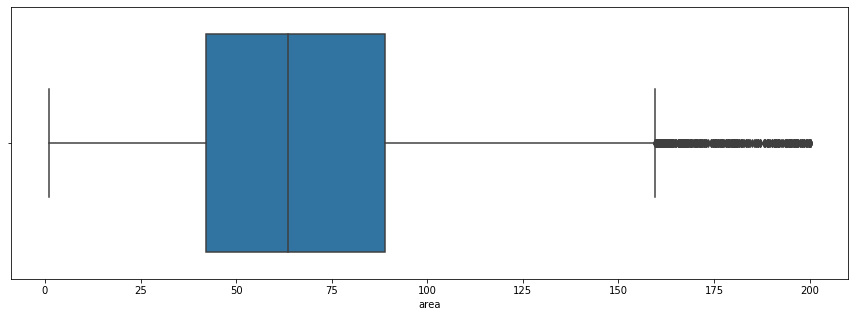

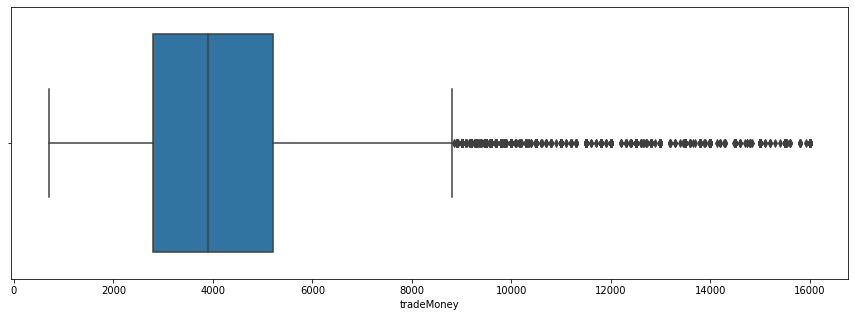

In [9]:
# 处理异常值后再次查看面积和租金分布图
plt.figure(figsize=(15,5))
sns.boxplot(data_train.area)
plt.show()
plt.figure(figsize=(15,5))
sns.boxplot(data_train.tradeMoney),
plt.show()

# 深度清洗

## 主要思路分析
针对每一个region的数据，对area和tradeMoney两个维度进行深度清洗。 
采用主观+数据可视化的方式。

In [11]:
def cleanData(data):
    data.drop(data[(data['region']=='RG00001') & (data['tradeMoney']<1000)&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['tradeMoney']>25000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>250)&(data['tradeMoney']<20000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>400)&(data['tradeMoney']>50000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>100)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00002') & (data['area']<100)&(data['tradeMoney']>60000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['area']<300)&(data['tradeMoney']>30000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<500)&(data['area']<50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<1500)&(data['area']>100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<2000)&(data['area']>300)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']>5000)&(data['area']<20)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['area']>600)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004') & (data['tradeMoney']<1000)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']<200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']<2000)&(data['area']>180)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>50000)&(data['area']<200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['area']>200)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00007') & (data['area']>100)&(data['tradeMoney']<2500)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['area']>200)&(data['tradeMoney']>25000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['area']>400)&(data['tradeMoney']<15000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']<3000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']>7000)&(data['area']<75)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']>12500)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004') & (data['area']>400)&(data['tradeMoney']>20000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008') & (data['tradeMoney']<2000)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009') & (data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009') & (data['area']>300)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009') & (data['area']>100)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00011') & (data['tradeMoney']<10000)&(data['area']>390)].index,inplace=True)
    data.drop(data[(data['region']=='RG00012') & (data['area']>120)&(data['tradeMoney']<5000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013') & (data['area']<100)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013') & (data['area']>400)&(data['tradeMoney']>50000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013') & (data['area']>80)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['area']>300)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<1300)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<8000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<1000)&(data['area']>20)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']>25000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<20000)&(data['area']>250)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>30000)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']<50000)&(data['area']>600)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>50000)&(data['area']>350)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']>4000)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']<600)&(data['area']>100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['area']>165)].index,inplace=True)
    data.drop(data[(data['region']=='RG00012') & (data['tradeMoney']<800)&(data['area']<30)].index,inplace=True)
    data.drop(data[(data['region']=='RG00007') & (data['tradeMoney']<1100)&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004') & (data['tradeMoney']>8000)&(data['area']<80)].index,inplace=True)
    data.loc[(data['region']=='RG00002')&(data['area']>50)&(data['rentType']=='合租'),'rentType']='整租'
    data.loc[(data['region']=='RG00014')&(data['rentType']=='合租')&(data['area']>60),'rentType']='整租'
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']>15000)&(data['area']<110)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']>20000)&(data['area']>110)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']<1500)&(data['area']<50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['rentType']=='合租')&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00015') ].index,inplace=True)
    data.reset_index(drop=True, inplace=True)
    return data

data_train = cleanData(data_train)